# COMP4211 PA2

Name: *redacted*  
Student ID: *redacted*


## Environment Setup

Let's set up the environment by installing some libraries. To ensure reproducibility, we'll install the same versions as specified in the document.

In [ ]:
colab = True # Whether or not we're running this from colab.
!pip install tensorflow==2.8.2 tensorflow-gpu==2.8.3 tensorflow-addons ffmpeg

In [4]:
# Sanity check.
!python --version
!pip freeze | grep -E 'numpy|matplotlib|pandas|tensorflow|keras'

Python 3.7.15
keras==2.8.0
keras-vis==0.4.1
matplotlib==3.2.2
matplotlib-venn==0.11.7
numpy==1.21.6
pandas==1.3.5
pandas-datareader==0.9.0
pandas-gbq==0.13.3
pandas-profiling==1.4.1
sklearn-pandas==1.8.0
tensorflow==2.8.2+zzzcolab20220929150707
tensorflow-addons==0.18.0
tensorflow-datasets==4.6.0
tensorflow-estimator==2.8.0
tensorflow-gcs-config==2.9.1
tensorflow-gpu==2.8.3
tensorflow-hub==0.12.0
tensorflow-io-gcs-filesystem==0.27.0
tensorflow-metadata==1.10.0
tensorflow-probability==0.16.0


In [5]:
# Imports.
import gzip
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import tensorflow_addons as tfa

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

## Helper functions.

We'll define a bunch of helper functions.

In [6]:
def load_training_images(filename):
    # https://stackoverflow.com/a/62781370/10239789
    with gzip.open(filename, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8).reshape((image_count, row_count, column_count))
        return images

def plot(img):
    plt.imshow(img, cmap=plt.cm.binary)

In [ ]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

In [8]:
# Load two sets of data.
# Training images: 60,000 hand-written digits (represented as 28x28) from the MNIST dataset.
# Pre-generated testing sequences: 10,000 20-frame sequences, with each frame being a 64x64 image.
if colab:
    train_im = load_training_images('drive/MyDrive/HKUST/COMP4211/train-images-idx3-ubyte.gz')
    test_seq = np.load('drive/MyDrive/HKUST/COMP4211/MNIST_test_seq.npy')
else:
    train_im = load_training_images('pa2_data/train-images-idx3-ubyte.gz')
    test_seq = np.load('pa2_data/MNIST_test_seq.npy')

# train_im = train_im / 255
# test_seq = test_seq / 255

print('train:', train_im.shape)
print('test:', test_seq.shape)

train: (60000, 28, 28)
test: (20, 10000, 64, 64)


In [9]:
if colab:
    pretrain_path = 'drive/MyDrive/HKUST/COMP4211/pretrained_main/pretrained_main'
else:
    pretrain_path = 'pa2_data/pretrained_main/pretrained_main'

In [10]:
# Constants!
Cs = 64
Ct = 256
Ns = 4
Nt = 8
W = H = 64
C = 1
N = 16
T = 10

## (4.1) Dataset and Data Generator

### [C1] [C2] [C3]
We create a new dataset class for handling the moving digits. The data imported will be split into multiple mini-batches.

There are five primary attributes to note:
* `batchsize` is the size of each mini-batch.
* `length` is the number of mini-batches.
* `mnist_train_im` is the set of training images.
* `mnist_test` and `mnist_valid` are testing sequences that both come from the video sequences loaded.


In [11]:
class MMNISTDataset(tf.keras.utils.Sequence):
    def __init__(self, mode, train=train_im, test=test_seq, *, length=None, batchsize=16, generate_tf_tensor=True):
      super().__init__()
      self.batchsize = batchsize
      # self.length = length

      assert mode in {'train', 'valid', 'test'}
      self.mode = mode

      self.mnist_train_im = train
      # self.mnist_test = test
      # self.mnist_valid = test
      self.mnist_test_og = test
      self.mnist_test, self.mnist_valid = np.split(test, [int(0.92 * test.shape[1])], axis=1)
      # print(self.mnist_test.shape, self.mnist_valid.shape)
      self.generate_tf_tensor = generate_tf_tensor

      if length:
        self.length = length
      else:
        # Auto-deduce length.
        if mode == 'train':
          self.length = len(self.mnist_train_im) // self.batchsize
          self.length = max(self.length,
                            self.mnist_test.shape[1] // self.batchsize,
                            self.mnist_valid.shape[1] // self.batchsize,
                            )
        elif mode == 'test':
          self.length = self.mnist_test.shape[1] // self.batchsize
        elif mode == 'valid':
          self.length = self.mnist_valid.shape[1] // self.batchsize
      
    def __len__(self):
      return self.length

    def __getitem__(self, idx):
        if self.mode == 'train':
          # Use training data and construct random sequences on the fly.
          ims = self.mnist_train_im[self.batchsize*idx : self.batchsize*(idx + 1)]
          
          # Generate random sequences on-the-fly. See piazza 226.
          seqs = np.array([MMNISTDataset.random_mmnist(ims) for _ in range(self.batchsize)])
          if self.generate_tf_tensor:
            seqs = tf.convert_to_tensor(seqs, dtype=tf.float32)
        elif self.mode == 'valid':
          seqs = np.array([self.mnist_valid[:, self.batchsize*idx + i] for i in range(self.batchsize)])
          if self.generate_tf_tensor:
            seqs = tf.convert_to_tensor(seqs, dtype=tf.float32)
        elif self.mode == 'test':
          seqs = np.array([self.mnist_test[:, self.batchsize*idx + i] for i in range(self.batchsize)])
          if self.generate_tf_tensor:
            seqs = tf.convert_to_tensor(seqs, dtype=tf.float32)

        seqs = seqs / 255
        seqs = seqs.reshape(list(seqs.shape) + [1]) # Add channel (greyscale => 1).
        assert seqs.shape == (self.batchsize, 20, 64, 64, 1), f'shape: {seqs.shape}'

        if self.generate_tf_tensor:
          return tf.split(seqs, 2, axis=1)
        else:
          return np.split(seqs, 2, axis=1)

    @staticmethod
    def gen_random_sequence():
        ''' randomly generate a sequence of a digit'''
        size = 64 - 28
        x, y, theta = random.random(), random.random(), random.random() * 2 * np.pi
        velocity_y, velocity_x = np.sin(theta), np.cos(theta) 
        seq_x, seq_y = np.zeros(20), np.zeros(20)

        for i in range(20):
            y += 0.1*velocity_y
            x += 0.1*velocity_x 

            if x <= 0:
                x = 0
                velocity_x = -velocity_x
            if x >= 1.0:
                x = 1.0
                velocity_x = -velocity_x
            if y <= 0:
                y = 0
                velocity_y = -velocity_y
            if y >= 1.0:
                y = 1.0
                velocity_y = -velocity_y
            seq_x[i], seq_y[i] = x, y

        # Scale to the size.
        seq_x = (size * seq_x).astype(np.int32)
        seq_y = (size * seq_y).astype(np.int32)
        return seq_y, seq_x

    @staticmethod
    def random_mmnist(mnist_train_im):
        ''' generate frames of moving mnist. '''
        data = np.zeros((20, 64, 64), dtype=np.float32) # 10 input + 10 groundtruth = 20
        for n in range(2):
            seq_y, seq_x = MMNISTDataset.gen_random_sequence()
            idx = random.randint(0, mnist_train_im.shape[0] - 1)
            mnist_image = mnist_train_im[idx]
            for i in range(20):
                # put the 2 moving digits into "data"
                data[i, seq_y[i]:seq_y[i]+28, seq_x[i]:seq_x[i]+28] = np.maximum(data[i, seq_y[i]:seq_y[i]+28, seq_x[i]:seq_x[i]+28], mnist_image)
        return data

In [12]:
# Test our dataset.
mmnist = MMNISTDataset('train')
seq_input, seq_ground_truth = mmnist[0]
assert seq_input.shape == seq_ground_truth.shape == (16, 10, 64, 64, 1)

## (4.2) Model Backbone

In this section, we'll implement a custom architecture built solely on CNN and use it as the backbone network of the video prediction model.

In [13]:
RESHAPE_WITH_FIXED_BATCH_SIZE = False

def input_to_encoder_reshape(x, *, fixed=RESHAPE_WITH_FIXED_BATCH_SIZE):
    if fixed:
        return tf.reshape(x, [N * T, H, W, C])
    else:
        return tf.reshape(x, [-1, H, W, C])

def encoder_to_translator_reshape(x, *, fixed=RESHAPE_WITH_FIXED_BATCH_SIZE):
    if fixed:
        x = tf.reshape(x, [N, T, H // 4, W // 4, Cs])
        x = tf.transpose(x, [0, 2, 3, 1, 4])
        x = tf.reshape(x, [N, H // 4, W // 4, T * Cs])
    else:
        x = tf.reshape(x, [-1, T, H // 4, W // 4, Cs])
        x = tf.transpose(x, [0, 2, 3, 1, 4])
        x = tf.reshape(x, [-1, H // 4, W // 4, T * Cs])
    return x

def translator_to_decoder_reshape(x, *, fixed=RESHAPE_WITH_FIXED_BATCH_SIZE):
    if fixed:
        x = tf.reshape(x, [N, H // 4, W // 4, T, Cs])
        x = tf.transpose(x, [0, 3, 1, 2, 4])
        x = tf.reshape(x, [N * T, H // 4, W // 4, Cs])
    else:
        x = tf.reshape(x, [-1, H // 4, W // 4, T, Cs])
        x = tf.transpose(x, [0, 3, 1, 2, 4])
        x = tf.reshape(x, [-1, H // 4, W // 4, Cs])
    return x

### [C4] [C5] Encoder and EncConvB

We define `Encoder` and `EncConvB` classes. The encoder is responsible for generating feature maps (aka channels). EncConvB uses convolution to select features.

In [14]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        self.enc = [ # List of Conv-B classes.
            EncConvB(Cs, stride=1),
            EncConvB(Cs, stride=2),
            EncConvB(Cs, stride=1),
            EncConvB(Cs, stride=2),
        ]

    def call(self, x):
        enc1 = self.enc[0]
        out0 = x = enc1(x)
        for enc in self.enc[1:]:
            x = enc(x)
        return [out0, x]

class EncConvB(layers.Layer):
    def __init__(self, C_out, stride):
        super(EncConvB, self).__init__()
        self.conv = layers.Conv2D(C_out, kernel_size=3, strides=(stride, stride), padding='same') # Conv2d layer.
        self.norm = tfa.layers.GroupNormalization(groups=2, epsilon=1e-5) # Group normalisation layer.
        self.act = layers.LeakyReLU(0.2) # Activation layer.

    def call(self, x):
        return self.act(self.norm(self.conv(x)))

### [Q1]

> What are the stride sizes $s_i$ of EncConvB-$i$ for $i =$ 1, 2, 3, 4? How do you compute these values?

$s_1 = s_3 = 1$, $s_2 = s_4 = 2$.

We can deduce these from the input and output dimensions. For example, across EncConvB-2, the dimension changes from $(NT, H, W, C_S)$ to $(NT, H/2, W/2, C_S)$, decreasing by a factor of 2. This decrease is achieved through striding (i.e. skipping across elements).


### [Q2]

The number of trainable parameters in the `Encoder` is 111,936 as can be seen below:

In [119]:
inputs = keras.Input((N, T, H, W, C))
residual, output = Encoder()(inputs)
model = keras.Model(inputs, output)
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 10, 64, 64,   0         
                             1)]                                 
                                                                 
 encoder_14 (Encoder)        [(None, 16, 10, 64, 64,   111936    
                             64),                                
                              (None, 16, 10, 16, 16,             
                             64)]                                
                                                                 
Total params: 111,936
Trainable params: 111,936
Non-trainable params: 0
_________________________________________________________________


### [C6] [C7] Translator and Inception

In [15]:
class Translator(layers.Layer):
    def __init__(self):
        super(Translator, self).__init__()
        
        self.enc = [] # List of Inception (IncEnc) classes.
        self.dec = [] # List of Inception (IncDec) classes.

        role = 'encoder'
        for i in range(8):
            (C_in, C_out) = self.get_channels(role, i+1)
            self.enc.append(Inception(role, C_in, C_out))
        
        role = 'decoder'
        for i in range(8):
            (C_in, C_out) = self.get_channels(role, i+1)
            self.dec.append(Inception(role, C_in, C_out))

    @staticmethod
    def get_channels(role, i):
        if role == 'encoder':
            if i == 1:
                return (T * Cs, Ct)
            else:
                return (Ct, Ct)
        else:
            if i == 1:
                return (Ct, Ct)
            elif i == 8:
                return (2 * Ct, T * Cs)
            else:
                return (2 * Ct, Ct)
    
    def call(self, x):
        out = []
        for enc in self.enc[:-1]:
            x = enc(x)
            out.append(x)
        
        x = self.enc[-1](x)
        x = self.dec[0](x)
        for dec, in_ in zip(self.dec[1:], out[::-1]):
            x = layers.Concatenate()([x, in_])
            x = dec(x)

        return x

class Inception(layers.Layer):
    def __init__(self, role, C_in, C_out):
        super(Inception, self).__init__()
        assert role in {'encoder', 'decoder'}
        self.conv1 = layers.Conv2D(Ct // 2, kernel_size=1, strides=(1, 1))
        k = [3, 5, 7, 11]
        self.layers = [GroupConv(k[i], C_out) for i in range(4)]

    def call(self, x):
        x = self.conv1(x)
        xs = [layer(x) for layer in self.layers]
        return layers.Add()(xs)

### [Q3]
> What are the integer values of the input channel size of `Inception.Conv` every time it is called?

For the first IncepEnc block, there are $T \times C_S = 640$ input channels.  
For the rest of the IncepEnc blocks, there are $C_T = 256$ input channels.  
The first IncepDec block also has $C_T = 256$ input channels.  
The rest of the IncepDec blocks have $2C_T = 512$ input channels, due to concatenating the previous output and residual output.

### [Q4]
> For Inception.Conv, if we use stride=(1, 1) and do not use padding, what should be its kernel size?

The kernel size would be 1, since we don't aim to change the width and height of the image.

### [C8] GroupConv

In [16]:
class GroupConv(layers.Layer):
    def __init__(self, k, C_out):
        super(GroupConv, self).__init__()
        self.conv = layers.Conv2D(C_out, kernel_size=k, strides=(1, 1), padding='same', groups=8) # Conv2d layer.
        self.norm = tfa.layers.GroupNormalization(groups=8, epsilon=1e-5) # Group normalisation layer.
        self.act = layers.LeakyReLU(0.2) # Activation layer.

    def call(self, x):
        return self.act(self.norm(self.conv(x)))

### [Q5]

> How many times in total is `GroupConv.GroupNorm` called in one forward pass through the whole network? (Please answer in integer value.) How did you get this number?

There are 16 `Inception` blocks, each with 4 `GroupConv` blocks, each having 1 `GroupNorm` layer. In total, there are 64 calls to `GroupNorm`.


### [Q6]

> For `GroupConv.conv`, what are its parameters $C_{out}$ (output channels) and $k$ (kernel size) each time it is called? (Please answer in integer values.)

The $C_{out}$ of `GroupConv.conv` and `Inception` are the same. Within each `Inception` block, the kernel sizes $k$ expected are 3, 5, 7, and 11.

Similar to `GroupConv.GroupNorm`, there are 64 `GroupConv.conv` layers. The respective $C_{out}$ and $k$ are given by the Cartesian product of:

```python
C_outs = [256]*15 + [640]
ks = [3, 5, 7, 11]
```

(The $C_{out}$ values are taken from the piecewise function.

### [C9] [C10] Decoder

In [17]:
class Decoder(layers.Layer):
    """
    The Decoder class. Expand height and width, and also reduce feature map.
    """
    def __init__(self):
        super(Decoder, self).__init__()
        C_out = [Cs, Cs, Cs, Cs]
        strides = [2, 1, 2, 1]
        self.dec = [DecConvB(i+1, C_out[i], stride=strides[i]) for i in range(4)] # List of DevConvB layers.
        self.readout = layers.Conv2D(C, kernel_size=1) # Conv2d layer.

    def call(self, x0, x1):
        for dec in self.dec[:-1]:
            x1 = dec(x1)

        x = layers.Concatenate()([x1, x0])
        x = self.dec[-1](x)
        return self.readout(x)

class DecConvB(layers.Layer):
    def __init__(self, i, C_out, stride):
        super(DecConvB, self).__init__()
        if i % 2:
            # Use Conv2DTranspose for deconvolution.
            # TODO: are we supposed to use Conv2DTranspose?
            self.conv = layers.Conv2DTranspose(C_out, kernel_size=3, strides=(stride, stride), output_padding=(1, 1), padding='same') # Conv2d/Conv2dTranspose layer.
        else:
            self.conv = layers.Conv2D(C_out, kernel_size=3, strides=(stride, stride), padding='same') # Conv2d/Conv2dTranspose layer.
            
        self.norm = tfa.layers.GroupNormalization(groups=2, epsilon=1e-5) # Group normalisation layer.
        self.act = layers.LeakyReLU(0.2) # Activation layer.
    
    def call(self, x):
        return self.act(self.norm(self.conv(x)))

### [Q7] 
> What are the values of the number of output channels $C^{Dec−i}_{out}$ for $i =$ 1, 2, 3, 4 in the decoder module?



### Model

In [18]:
class Model(layers.Layer):
# class Model(keras.Model):
    """
    The Model class. Handles the three main layers: Encoder, Translator, and Decoder;
    and the interrelationship between them. Reshapes tensors as necessary.
    """
    def __init__(self, *, fixed_batch_size=False, **kwargs):
        super(Model, self).__init__(**kwargs)
        self.enc = Encoder() # Encoder class.
        self.hid = Translator() # Translator class.
        self.dec = Decoder() # Decoder class.
        self.fixed_batch_size = fixed_batch_size
    
    def call(self, x):
        # Encoder.
        x = input_to_encoder_reshape(x, fixed=self.fixed_batch_size)
        x0, x1 = self.enc(x)

        # Translator.
        x2 = encoder_to_translator_reshape(x1, fixed=self.fixed_batch_size)
        x3 = self.hid(x2)

        # Decoder.
        x4 = translator_to_decoder_reshape(x3, fixed=self.fixed_batch_size)
        res = self.dec(x0, x4)
        if self.fixed_batch_size:
            res = tf.reshape(res, (N, T, H, W, 1))
        else:
            res = tf.reshape(res, (-1, T, H, W, 1))
        return res

    @staticmethod
    def plot(fixed=False):
        input = keras.Input(shape=(T, H, W, C))
        model = keras.Model(inputs=input, outputs=Model(fixed_batch_size=fixed).call(input))
        return keras.utils.plot_model(model, show_shapes=True)

In [19]:
# Test the model.
input_shape = (N, T, H, W, C)
print(f'N={N} T={T} H={H} W={W} C={C} Cs={Cs} Ct={Ct}')
print('input shape:', input_shape)

# model = Model()
model = models.Sequential(Model())
model.build(input_shape)
model.summary()

N=16 T=10 H=64 W=64 C=1 Cs=64 Ct=256
input shape: (16, 10, 64, 64, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Model)               (16, 10, 64, 64, 1)       15778433  
                                                                 
Total params: 15,778,433
Trainable params: 15,778,433
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Model.plot()

## (4.3) Load the Pretrained Weights

### [C11]

In [104]:
from keras.metrics import *

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# model = Model()
model = models.Sequential(Model())
model.compile(optimizer, loss=tf.keras.losses.MSE, metrics=[MAE, MSE])

test = MMNISTDataset('test')

In [ ]:
# Pre-loading, pre-training evaluation.
model.evaluate(test, return_dict=True)

575/575 [==============================] - 137s 222ms/step - loss: 1.1300 - mean_absolute_error: 0.6164 - mean_squared_error: 1.1300


{'loss': 1.1299844980239868,
 'mean_absolute_error': 0.6163573861122131,
 'mean_squared_error': 1.129984736442566}

In [106]:
# Post-loading, pre-training evaluation.
model.load_weights(pretrain_path)
model.evaluate(test, return_dict=True)

575/575 [==============================] - 136s 236ms/step - loss: 0.0182 - mean_absolute_error: 0.0478 - mean_squared_error: 0.0182


{'loss': 0.018178675323724747,
 'mean_absolute_error': 0.04781317338347435,
 'mean_squared_error': 0.018178656697273254}

As can be seen above, the loss *before* loading weights is **1.1300**, whereas the loss *after* loading weights has improved to **0.0182**.

## (4.4) Evaluation Metrics

There are four metrics we're interested in Mean Squared Error (MSE), Mean Absolute Error (MAE), Structural Similarity Index Measure (SSIM), and Peak-to-Signal Noise Ratio (PSNR).

Let's first define functions for each of these:

In [107]:
def mean_squared_error(y_pred, y_true):
  return np.mean((y_true - y_pred)**2, axis=0) # `axis=0` to compute error PER BATCH.

def mean_absolute_error(y_pred, y_true):
  return np.mean(np.abs(y_true - y_pred), axis=0) # `axis=0` to compute error PER BATCH.

from skimage.metrics import structural_similarity

def ssim(Y_pred, Y_true, **kwargs):
  # print('ssim:', Y_pred.shape, Y_true.shape)
  return np.mean([structural_similarity(im1, im2, **kwargs) for im1, im2 in zip(Y_pred, Y_true)], axis=0)

def psnr(Y_pred, Y_true):
  # print('psnr:', Y_pred.shape, Y_true.shape)
  def mse_(y_pred, y_true):
    return mean_squared_error(255 * y_pred, 255 * y_true)
  def psnr_(y_pred, y_true):
    # 20*log(255, 10) == 48.1308...
    # 10/log(10) == 4.342944
    return 48.13080360867909 - 4.3429448190325175 * np.log(mse_(y_pred, y_true))
    
  return np.mean([psnr_(im1, im2) for im1, im2 in zip(Y_pred, Y_true)], axis=0)

Let's also define a helper function to help evaluate metrics against a model and test dataset.

In [108]:
from collections import defaultdict

def evaluate_metrics(model, test, metrics, n=None):
  data = defaultdict(list)
  if n is None:
    n = len(test)
  for i in range(n):
    # Iterate through each batch and predict.
    X_test, Y_true = test[i]
    Y_pred = model.predict(X_test)
    shape = (N*T, H*W)
    Y_pred, Y_true = tf.reshape(Y_pred, shape), tf.reshape(Y_true, shape)
    Y_pred = np.clip(Y_pred, 0, 1)
    for m in metrics:
      data[m.__name__].append(np.sum(m(Y_pred, Y_true)))

  return {mname: np.mean(val) for mname, val in data.items()}

In [110]:
# Custom metrics before training...
model.load_weights(pretrain_path)
evaluate_metrics(model, test, [mean_squared_error, mean_absolute_error, ssim, psnr])

{'mean_squared_error': 75.03405,
 'mean_absolute_error': 196.9933,
 'ssim': 0.7248585266827021,
 'psnr': 17.786265145687562}

## (4.5) Rundown

Finally, let's run through the whole process of training (fitting), predicting, and evaluating metrics.

Let's first initialise our model and datasets.

In [114]:
train = MMNISTDataset('train')
test = MMNISTDataset('test')
valid = MMNISTDataset('valid')

Let's also backup our data by defining a checkpoint callback. This way, TensorFlow will save our weights after every epoch.

In [112]:
if colab:
    checkpoint_path = 'drive/MyDrive/HKUST/COMP4211/checkpoint_main/checkpoint_main'
else:
    checkpoint_path = 'pa2_data/checkpoint_main/checkpoint_main'

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

### [C12]: Fitting Time!

In [113]:
model = keras.Sequential(Model())
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MSE,
    metrics=[MAE, MSE])

# Train params.
result = model.fit(train, validation_data=valid, epochs=10, callbacks=[cp_callback])
hist = result.history
print(hist)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.0954 - mean_absolute_error: 0.1311 - mean_squared_error: 0.0954
Epoch 1: saving model to drive/MyDrive/HKUST/COMP4211/checkpoint_main/checkpoint_main
100/100 [==============================] - 114s 853ms/step - loss: 0.0954 - mean_absolute_error: 0.1311 - mean_squared_error: 0.0954 - val_loss: 0.0374 - val_mean_absolute_error: 0.1037 - val_mean_squared_error: 0.0374
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.0920 - mean_squared_error: 0.0348
Epoch 2: saving model to drive/MyDrive/HKUST/COMP4211/checkpoint_main/checkpoint_main
100/100 [==============================] - 81s 810ms/step - loss: 0.0348 - mean_absolute_error: 0.0920 - mean_squared_error: 0.0348 - val_loss: 0.0341 - val_mean_absolute_error: 0.0895 - val_mean_squared_error: 0.0341
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0833 - mean_squar

### [C13]

In [115]:
# Check how well model prediction performs now that we've trained it.
evaluate_metrics(model, test, [mean_squared_error, mean_absolute_error, ssim, psnr], n=100)

{'mean_squared_error': 121.267235,
 'mean_absolute_error': 278.03586,
 'ssim': 0.6438133473923258,
 'psnr': 15.477940321589934}

Let's get a random test sequence and try the model on it.

In [75]:
# Cherry pick 1 sample from the test pool.
import random

n = test_seq.shape[1]
sample_index = random.randint(0, n)
sample = test_seq[:, sample_index]
X, Y_true = sample[:10], sample[10:]

# model = models.Sequential(Model())
# model.load_weights(pretrain_path)

X = tf.reshape(tf.convert_to_tensor(X), (1, 10, 64, 64, 1)) / 255

# Predict.
Y_pred = model.predict(X)

Y_pred = tf.reshape(Y_pred, (10, 64, 64)) * 255
Y_pred = Y_pred.numpy()

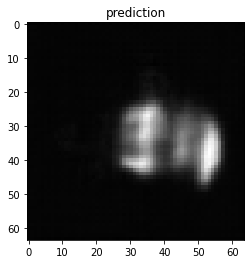

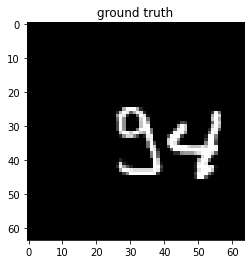

In [103]:
from IPython.display import display, HTML
import matplotlib.animation as animation

def make_video(seq, *, title=None):
  """
  Display an iterable of frames.
  """
  fig = plt.figure()

  def plot_frame(frame, *args):
      im = plt.imshow(frame, cmap='gray')
      im.axes.set_title(title)
      return im,

  ani = animation.FuncAnimation(fig, plot_frame, frames=seq, blit=True)
  return HTML(ani.to_html5_video())

# Display prediction video.
display(make_video(Y_pred, title='prediction'))
display(make_video(Y_true, title='ground truth'))
# View the videos on Colab: https://colab.research.google.com/drive/1kyzTM0SWSJkRx1j5pStyH3mIBTLwox_V?usp=sharing

### [C14]

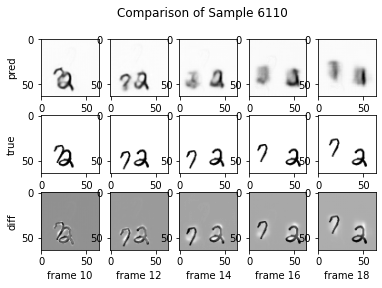

In [71]:
fig, axs = plt.subplots(3, 5)
fig.suptitle(f'Comparison of Sample {sample_index}')
for i in range(5):
  axs[0, i].imshow(Y_pred[i*2], cmap=plt.cm.binary)
  axs[1, i].imshow(Y_true[i*2], cmap=plt.cm.binary)
  axs[2, i].imshow(Y_true[i*2] - Y_pred[i*2], cmap=plt.cm.binary)
  axs[2, i].set_xlabel(f'frame {10+2*i}')

axs[0, 0].set_ylabel('pred')
axs[1, 0].set_ylabel('true')
axs[2, 0].set_ylabel('diff')
None

### [Q10]

The predicted output is fairly accurate for the first 3-5 frames. The general position of clusters are fairly accurate (as can be seen in the cloudy differences), but the details are fuzzy and lacking.